In [ ]:
# Cell 1: Install necessary library (run this cell first if needed)
!pip install Faker

#------------------------------------------------------------------

# Cell 2: Generate and Save Data (run this cell after installing Faker)
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta
import os # <--- Import the 'os' module

print("Libraries imported.")

# Initialize Faker
fake = Faker()
print("Faker initialized.")

# --- Configuration ---
NUM_PATIENTS = 2000
NUM_HCPS = 300
NUM_PRESCRIPTIONS = 50000
START_DATE = datetime(2022, 1, 1)
END_DATE = datetime(2024, 6, 30) # ~2.5 years of data
CARDIOGUARD_LAUNCH_DATE = datetime(2023, 6, 1)

DRUGS = ["CardioGuard", "CompetitorA", "CompetitorB", "GenericX", "GenericY", "OtherCVD"]
HCP_SPECIALTIES = ["Cardiology", "Internal Medicine", "PCP", "Geriatrics"]
AGE_GROUPS = ["45-54", "55-64", "65-74", "75+"]
ZIP_PREFIXES = [str(random.randint(100, 999)) for _ in range(50)] # Simulate 50 regions

print("Configuration set.")

# --- Generate Patients ---
print("Generating patients...")
patients_data = []
for i in range(NUM_PATIENTS):
    # Ensure enrollment allows for potential prescriptions before END_DATE
    max_enroll_days = (END_DATE - START_DATE).days - 90 # Enroll at least 90 days before end
    if max_enroll_days <=0: max_enroll_days = 1 # Handle edge case for short date range
    enroll_date = START_DATE + timedelta(days=random.randint(0, max_enroll_days))
    patients_data.append({
        "patient_id": 1000 + i,
        "age_group": random.choice(AGE_GROUPS),
        "gender": random.choice(["M", "F"]),
        "zip_prefix": random.choice(ZIP_PREFIXES),
        "enrollment_date": enroll_date.strftime('%Y-%m-%d')
    })
patients_df = pd.DataFrame(patients_data)
print(f"Generated {len(patients_df)} patients.")

# --- Generate HCPs ---
print("Generating HCPs...")
hcps_data = []
for i in range(NUM_HCPS):
    hcps_data.append({
        "hcp_id": 500 + i,
        "specialty": random.choice(HCP_SPECIALTIES),
        "zip_prefix": random.choice(ZIP_PREFIXES)
    })
hcps_df = pd.DataFrame(hcps_data)
print(f"Generated {len(hcps_df)} HCPs.")

# --- Generate Prescriptions (More Complex Simulation) ---
print("Generating prescriptions (this may take a moment)...")
prescriptions_data = []
prescription_id_counter = 90000

# Define HCP prescribing tendencies (some early adopters, some high volume)
hcp_profile = {}
for hcp_id in hcps_df['hcp_id']:
    hcp_profile[hcp_id] = {
        'prescribing_volume_factor': random.uniform(0.5, 1.5), # Multiplier for likelihood
        'cardioguard_adoption_propensity': random.uniform(0.0, 1.0), # Higher means more likely/earlier adopter
        'cardioguard_prescribed_flag': False # Track if they ever prescribed CG
    }

# Convert enrollment_date to datetime for faster lookups
patients_df['enrollment_date_dt'] = pd.to_datetime(patients_df['enrollment_date'])
patient_enrollment_map = patients_df.set_index('patient_id')['enrollment_date_dt'].to_dict()

# Pre-calculate some values
available_drugs_no_cg = [d for d in DRUGS if d != "CardioGuard"]
days_since_launch_total = (END_DATE - CARDIOGUARD_LAUNCH_DATE).days
cardioguard_launch_date_dt = pd.to_datetime(CARDIOGUARD_LAUNCH_DATE)

# Assign prescriptions more realistically based on HCP volume
hcp_ids_list = hcps_df['hcp_id'].tolist()
hcp_weights = [hcp_profile[h_id]['prescribing_volume_factor'] for h_id in hcp_ids_list]
# Normalize weights
total_weight = sum(hcp_weights)
hcp_probabilities = [w / total_weight for w in hcp_weights]


for i in range(NUM_PRESCRIPTIONS):
    # Choose patient and HCP (HCP choice weighted by volume factor)
    patient_id = random.choice(patients_df['patient_id'])
    hcp_id = random.choices(hcp_ids_list, weights=hcp_probabilities, k=1)[0]

    # Ensure prescription date is after patient enrollment
    patient_enroll_date = patient_enrollment_map.get(patient_id)
    if patient_enroll_date is None: continue # Should not happen with clean data

    max_days_since_enroll = (END_DATE - patient_enroll_date).days
    # Ensure there's at least one day to prescribe
    if max_days_since_enroll <= 0 :
      prescription_date = patient_enroll_date # Prescribe on enrollment day if at END_DATE
    else:
       prescription_date = patient_enroll_date + timedelta(days=random.randint(1, max_days_since_enroll))

    # Determine drug based on launch date and HCP profile
    drug_name = random.choice(available_drugs_no_cg) # Default to competitors/generics
    is_after_launch = prescription_date >= cardioguard_launch_date_dt

    if is_after_launch:
        # Simulate adoption probability
        profile = hcp_profile[hcp_id]
        # Probability increases closer to END_DATE and with higher propensity
        time_factor = max(0, (prescription_date - cardioguard_launch_date_dt).days) / days_since_launch_total if days_since_launch_total > 0 else 0
        # Base probability influenced by propensity, time, and overall volume desire
        adoption_prob = profile['cardioguard_adoption_propensity'] * time_factor * 0.5 # Adjust 0.5 factor to control overall CardioGuard share

        if random.random() < adoption_prob :
             drug_name = "CardioGuard"
             profile['cardioguard_prescribed_flag'] = True # Mark HCP as having prescribed it

    days_supply = random.choice([30, 60, 90])

    prescriptions_data.append({
        "prescription_id": prescription_id_counter + i,
        "patient_id": patient_id,
        "hcp_id": hcp_id,
        "drug_name": drug_name,
        "prescription_date": prescription_date.strftime('%Y-%m-%d'),
        "days_supply": days_supply
    })

prescriptions_df = pd.DataFrame(prescriptions_data)
# Clean up temporary column
patients_df = patients_df.drop(columns=['enrollment_date_dt'])

print(f"Generated {len(prescriptions_df)} prescriptions.")

# --- Create Output Directory ---
output_dir = "data"
os.makedirs(output_dir, exist_ok=True) # Creates the 'data' directory if it doesn't exist
print(f"Ensured output directory '{output_dir}' exists.")

# --- Save Data ---
print(f"Saving data to '{output_dir}'...")
patients_path = os.path.join(output_dir, "patients.csv")
hcps_path = os.path.join(output_dir, "hcps.csv")
prescriptions_path = os.path.join(output_dir, "prescriptions.csv")

patients_df.to_csv(patients_path, index=False)
hcps_df.to_csv(hcps_path, index=False)
prescriptions_df.to_csv(prescriptions_path, index=False)

print(f"\nData generation complete and saved to '{output_dir}' directory.")
print(f"Generated {len(patients_df)} patients.")
print(f"Generated {len(hcps_df)} HCPs.")
print(f"Generated {len(prescriptions_df)} prescriptions.")
print("\nSample Prescriptions:")
print(prescriptions_df.head())

# You can verify the folder exists using the left-hand file panel in Colab
# Or by running a code cell with: !ls data

Libraries imported.
Faker initialized.
Configuration set.
Generating patients...
Generated 2000 patients.
Generating HCPs...
Generated 300 HCPs.
Generating prescriptions (this may take a moment)...
Generated 50000 prescriptions.
Ensured output directory 'data' exists.
Saving data to 'data'...

Data generation complete and saved to 'data' directory.
Generated 2000 patients.
Generated 300 HCPs.
Generated 50000 prescriptions.

Sample Prescriptions:
   prescription_id  patient_id  hcp_id drug_name prescription_date  \
0            90000        2641     737  GenericY        2023-10-30   
1            90001        1930     532  OtherCVD        2024-05-07   
2            90002        1734     606  GenericY        2023-07-27   
3            90003        1463     675  OtherCVD        2023-06-03   
4            90004        2040     762  OtherCVD        2024-03-21   

   days_supply  
0           60  
1           90  
2           90  
3           30  
4           60  


In [ ]:
# Cell 3: Data Preprocessing (run this cell after generating data in Cell 2)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Good practice to potentially use os.path.join if needed

print("Libraries imported.")

# --- Define Data Directory ---
# Assuming the 'data' folder is in the same directory as the notebook is running
data_dir = "data"

# --- Load Data ---
print(f"Loading data from '{data_dir}' directory...")
patients_path = os.path.join(data_dir, "patients.csv")
hcps_path = os.path.join(data_dir, "hcps.csv")
prescriptions_path = os.path.join(data_dir, "prescriptions.csv")

try:
    patients_df = pd.read_csv(patients_path)
    hcps_df = pd.read_csv(hcps_path)
    prescriptions_df = pd.read_csv(prescriptions_path)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data generation cell (Cell 2) was run successfully and the 'data' folder exists.")
    # You might want to stop execution here if files aren't found
    raise e # Stop execution if files are missing

# --- Data Cleaning & Type Conversion ---
print("Performing data cleaning and type conversions...")
# Convert date columns to datetime objects
prescriptions_df['prescription_date'] = pd.to_datetime(prescriptions_df['prescription_date'])
patients_df['enrollment_date'] = pd.to_datetime(patients_df['enrollment_date'])
print("Date columns converted.")

# --- Merge Data ---
print("Merging dataframes...")
# Merge prescriptions with patient info
# Using how='left' keeps all prescription records, adding patient info where available
df = pd.merge(prescriptions_df, patients_df, on='patient_id', how='left')

# Merge with HCP info
# Using how='left' keeps all prescription records, adding HCP info where available
df = pd.merge(df, hcps_df, on='hcp_id', how='left')
print("Dataframes merged.")

# --- Feature Engineering ---
print("Performing feature engineering...")

# Calculate prescription end date (approximate based on days_supply)
# Adding timedelta requires the unit parameter
df['prescription_end_date'] = df['prescription_date'] + pd.to_timedelta(df['days_supply'], unit='D')
print("Calculated 'prescription_end_date'.")

# --- Important: Sort before calculating flags based on order ---
# Sort by patient, then drug, then date for 'is_new_to_drug'
df = df.sort_values(by=['patient_id', 'drug_name', 'prescription_date'], ascending=[True, True, True])

# Identify first prescription for each patient-drug combination
# duplicated() checks subsequent rows; '~' negates it (so True for the first occurrence)
df['is_new_to_drug'] = ~df.duplicated(subset=['patient_id', 'drug_name'], keep='first')
print("Calculated 'is_new_to_drug'.")

# Sort by patient, then date for 'is_first_rx_overall'
df = df.sort_values(by=['patient_id', 'prescription_date'], ascending=[True, True])

# Identify first prescription overall for each patient
df['is_first_rx_overall'] = ~df.duplicated(subset=['patient_id'], keep='first')
print("Calculated 'is_first_rx_overall'.")

# CardioGuard Specific flags
# Ensure the launch date is a datetime object for comparison
CARDIOGUARD_LAUNCH_DATE = pd.to_datetime("2023-06-01")

df['is_cardioguard'] = (df['drug_name'] == 'CardioGuard')
print("Calculated 'is_cardioguard'.")

# Calculate days since launch (can be negative for pre-launch prescriptions)
df['days_since_launch'] = (df['prescription_date'] - CARDIOGUARD_LAUNCH_DATE).dt.days
print("Calculated 'days_since_launch'.")

# --- Reset index after sorting (optional but can be helpful) ---
df = df.reset_index(drop=True)

# --- Check Data ---
print("\n--- Preprocessed Data Info ---")
df.info()

print("\n--- Preprocessed Data Head (First 5 Rows) ---")
print(df.head())

print("\n--- Preprocessed Data Sample (Random 5 Rows) ---")
print(df.sample(5))

print("\n--- Value Counts for Key New Columns ---")
print("\nIs New to Drug:")
print(df['is_new_to_drug'].value_counts())
print("\nIs First Rx Overall:")
print(df['is_first_rx_overall'].value_counts())
print("\nIs CardioGuard:")
print(df['is_cardioguard'].value_counts())

# The DataFrame 'df' now holds the preprocessed data and is ready for the next analysis step.
# You don't necessarily need to save it to a file in Colab if the next step is in the same notebook session.
print("\nPreprocessing complete. The DataFrame 'df' is ready for analysis.")

Libraries imported.
Loading data from 'data' directory...
Data loaded successfully.
Performing data cleaning and type conversions...
Date columns converted.
Merging dataframes...
Dataframes merged.
Performing feature engineering...
Calculated 'prescription_end_date'.
Calculated 'is_new_to_drug'.
Calculated 'is_first_rx_overall'.
Calculated 'is_cardioguard'.
Calculated 'days_since_launch'.

--- Preprocessed Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   prescription_id        50000 non-null  int64         
 1   patient_id             50000 non-null  int64         
 2   hcp_id                 50000 non-null  int64         
 3   drug_name              50000 non-null  object        
 4   prescription_date      50000 non-null  datetime64[ns]
 5   days_supply            50000 non-null  int64     

Lifelines library already installed.
DataFrame 'df' found. Starting Patient Journey Analysis.
Ensured output directory 'figures' exists for saving plots.

--- 1. Analyzing Patient Cohorts ---
Total unique patients in dataset: 2000
Number of CardioGuard Initiators identified: 1810

Demographics of CardioGuard Initiators:
Age Group Distribution:
age_group
45-54    26.353591
55-64    25.469613
65-74    22.872928
75+      25.303867
Name: proportion, dtype: float64

Gender Distribution:
gender
M    50.939227
F    49.060773
Name: proportion, dtype: float64


<ipython-input-9-e74ab9d29c43>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=initiator_demographics, y='age_group', order=age_order, palette='viridis')
<ipython-input-9-e74ab9d29c43>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=initiator_demographics, y='gender', palette='viridis')


Saved graph: figures/01_initiator_demographics.png


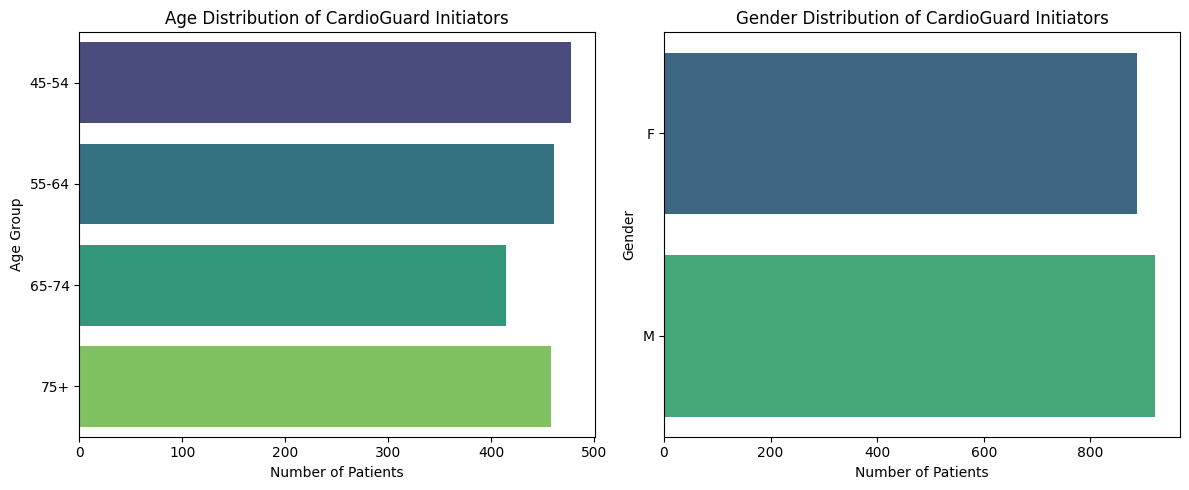


--- 2. Analyzing Lines of Therapy (Simplified) ---

CardioGuard Line of Therapy Distribution (Simplified):
lot_simplified
2L+                       95.469613
1L (First Recorded Tx)     4.530387
Name: proportion, dtype: float64


<ipython-input-9-e74ab9d29c43>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=lot_df, x='lot_simplified', order=lot_distribution.index, palette='magma')


Saved graph: figures/02_lot_distribution.png


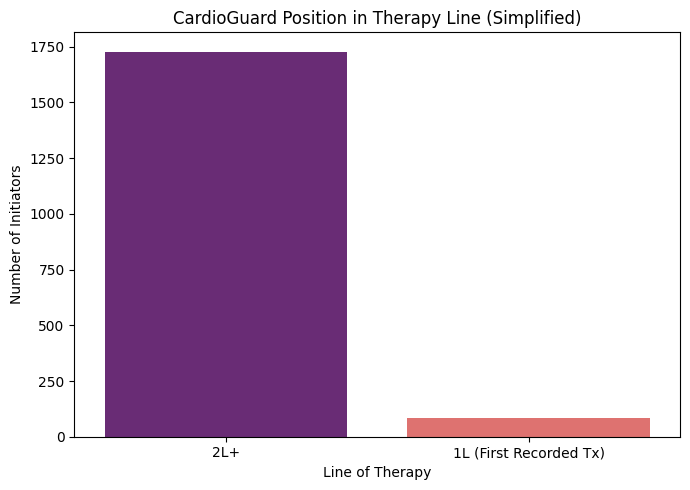


--- 3. Analyzing Persistency ---

Persistency Analysis Results (Sample):
   patient_id  duration_days  observed_discontinuation
0        1001            152                     False
1        1002            160                     False
2        1003            289                     False
3        1004            146                     False
4        1005            268                     False
Median Persistency (days): 131
Mean Persistency (days): 143
Number of Censored Patients (still on therapy at data end): 1341
Saved graph: figures/03_persistency_kaplan_meier.png


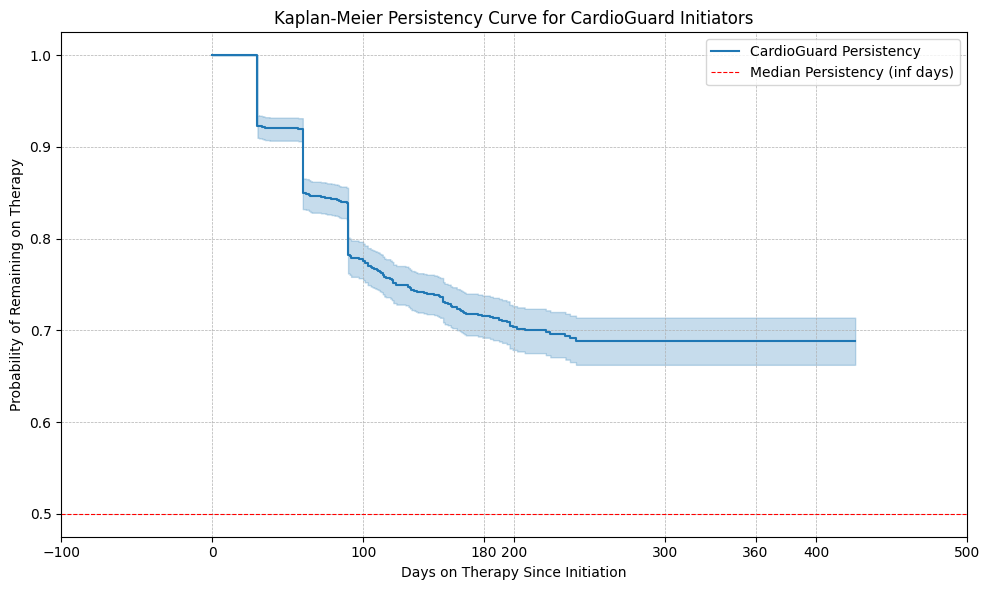


--- 4. Analyzing Compliance (MPR) ---

Compliance Analysis Results (MPR First 180 Days):
   patient_id  mpr_first_180_days
0        1001            0.833333
1        1002            0.833333
2        1003            0.811111
3        1004            0.666667
4        1005            0.516667
Average MPR: 59.78%
Median MPR: 58.89%
Saved graph: figures/04_compliance_mpr_distribution.png


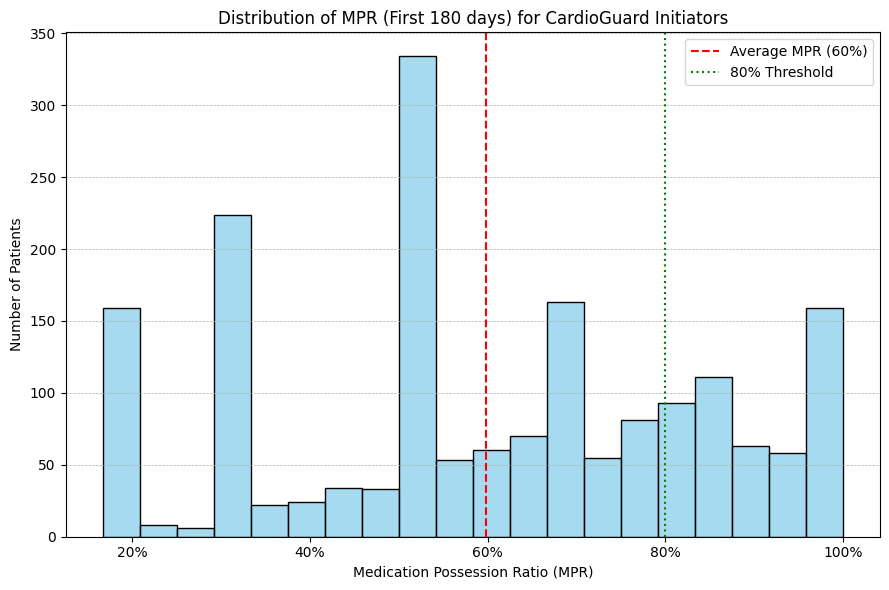


--- Patient Journey Analysis Complete ---


In [ ]:
# Cell 4: Patient Journey Analysis (run after preprocessing in Cell 3)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for directory creation and path joining

# This library is needed for Kaplan-Meier persistency curves
try:
    from lifelines import KaplanMeierFitter
    print("Lifelines library already installed.")
except ImportError:
    print("Lifelines library not found. Installing...")
    !pip install -q lifelines # Use -q for quieter install
    from lifelines import KaplanMeierFitter
    print("Lifelines library installed and imported.")


# --- Check if df exists (optional sanity check) ---
if 'df' not in locals():
    print("Error: DataFrame 'df' not found. Please run the preprocessing cell (Cell 3) first.")
    raise NameError("DataFrame 'df' not defined.")
else:
    print("DataFrame 'df' found. Starting Patient Journey Analysis.")

# Make sure launch date is defined (if not carried over explicitly)
CARDIOGUARD_LAUNCH_DATE = pd.to_datetime("2023-06-01")

# --- Create Figures Directory ---
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)
print(f"Ensured output directory '{figures_dir}' exists for saving plots.")

# --- 1. Patient Cohorts: CardioGuard Initiators ---
print("\n--- 1. Analyzing Patient Cohorts ---")
cardioguard_initiations = df[(df['is_cardioguard']) & (df['is_new_to_drug'])].copy()
cardioguard_initiator_ids = cardioguard_initiations['patient_id'].unique()
num_initiators = len(cardioguard_initiator_ids)

print(f"Total unique patients in dataset: {df['patient_id'].nunique()}")
print(f"Number of CardioGuard Initiators identified: {num_initiators}")

if num_initiators > 0:
    initiator_demographics = df[df['patient_id'].isin(cardioguard_initiator_ids)][['patient_id', 'age_group', 'gender']].drop_duplicates().reset_index(drop=True)
    print("\nDemographics of CardioGuard Initiators:")
    print("Age Group Distribution:")
    print(initiator_demographics['age_group'].value_counts(normalize=True).sort_index() * 100)
    print("\nGender Distribution:")
    print(initiator_demographics['gender'].value_counts(normalize=True) * 100)

    # --- Visualization: Initiator Demographics ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    age_order = sorted(initiator_demographics['age_group'].unique())
    sns.countplot(data=initiator_demographics, y='age_group', order=age_order, palette='viridis')
    plt.title('Age Distribution of CardioGuard Initiators')
    plt.xlabel('Number of Patients')
    plt.ylabel('Age Group')
    plt.subplot(1, 2, 2)
    sns.countplot(data=initiator_demographics, y='gender', palette='viridis')
    plt.title('Gender Distribution of CardioGuard Initiators')
    plt.xlabel('Number of Patients')
    plt.ylabel('Gender')
    plt.tight_layout()
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "01_initiator_demographics.png") # Added number prefix
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()

else:
    print("Skipping demographics visualization as no initiators were found.")


# --- 2. Lines of Therapy (LoT) ---
print("\n--- 2. Analyzing Lines of Therapy (Simplified) ---")
lot_df = pd.DataFrame() # Initialize empty dataframe
if num_initiators > 0:
    lot_data = []
    cg_first_rx_dates = cardioguard_initiations.set_index('patient_id')['prescription_date']
    for patient_id in cardioguard_initiator_ids:
        patient_df = df[df['patient_id'] == patient_id].sort_values('prescription_date')
        first_cg_date = cg_first_rx_dates.loc[patient_id]
        prior_drugs_df = patient_df[patient_df['prescription_date'] < first_cg_date]
        prior_drug_names = prior_drugs_df['drug_name'].unique()
        line = "1L (First Recorded Tx)" if len(prior_drug_names) == 0 else "2L+"
        lot_data.append({'patient_id': patient_id, 'lot_simplified': line, 'prior_drugs': list(prior_drug_names)})
    lot_df = pd.DataFrame(lot_data)

if not lot_df.empty:
    print("\nCardioGuard Line of Therapy Distribution (Simplified):")
    lot_distribution = lot_df['lot_simplified'].value_counts(normalize=True) * 100
    print(lot_distribution)

    # --- Visualization: LoT Distribution ---
    plt.figure(figsize=(7, 5))
    sns.countplot(data=lot_df, x='lot_simplified', order=lot_distribution.index, palette='magma')
    plt.title('CardioGuard Position in Therapy Line (Simplified)')
    plt.ylabel('Number of Initiators')
    plt.xlabel('Line of Therapy')
    plt.tight_layout()
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "02_lot_distribution.png") # Added number prefix
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()

else:
    print("Skipping Line of Therapy analysis/visualization as no initiators or LoT data generated.")


# --- 3. Persistency Analysis (Time on Therapy using Kaplan-Meier) ---
print("\n--- 3. Analyzing Persistency ---")
persistence_df = pd.DataFrame() # Initialize empty dataframe
if num_initiators > 0:
    persistence_data = []
    MAX_ALLOWED_GAP = 90
    DATA_END_DATE = df['prescription_date'].max()
    for patient_id in cardioguard_initiator_ids:
        patient_cg_df = df[(df['patient_id'] == patient_id) & (df['is_cardioguard'])].sort_values('prescription_date').reset_index()
        if len(patient_cg_df) == 0: continue
        start_date = patient_cg_df['prescription_date'].iloc[0]
        last_continuous_end_date = start_date - pd.to_timedelta(1, unit='D')
        discontinued = False; observed_duration = 0; observed_event = True
        for i in range(len(patient_cg_df)):
            current_rx = patient_cg_df.iloc[i]
            current_rx_start_date = current_rx['prescription_date']
            current_rx_end_date = current_rx['prescription_end_date']
            gap = (current_rx_start_date - last_continuous_end_date).days
            if gap > MAX_ALLOWED_GAP:
                discontinued = True; observed_duration = (last_continuous_end_date - start_date).days; break
            last_continuous_end_date = max(last_continuous_end_date, current_rx_end_date)
        if not discontinued:
            observed_duration = (last_continuous_end_date - start_date).days
            observed_event = False if last_continuous_end_date >= (DATA_END_DATE - pd.to_timedelta(MAX_ALLOWED_GAP, unit='d')) else True
        duration = max(0, observed_duration)
        persistence_data.append({'patient_id': patient_id, 'duration_days': duration, 'observed_discontinuation': observed_event})
    persistence_df = pd.DataFrame(persistence_data)

if not persistence_df.empty:
    print("\nPersistency Analysis Results (Sample):")
    print(persistence_df.head())
    print(f"Median Persistency (days): {persistence_df['duration_days'].median():.0f}")
    print(f"Mean Persistency (days): {persistence_df['duration_days'].mean():.0f}")
    censored_count = len(persistence_df[~persistence_df['observed_discontinuation']])
    print(f"Number of Censored Patients (still on therapy at data end): {censored_count}")

    # --- Visualization: Kaplan-Meier Survival Curve ---
    kmf = KaplanMeierFitter()
    kmf.fit(durations=persistence_df['duration_days'], event_observed=persistence_df['observed_discontinuation'], label='CardioGuard Persistency')
    median_survival = kmf.median_survival_time_ # Calculate before plotting

    plt.figure(figsize=(10, 6))
    kmf.plot_survival_function()
    plt.title('Kaplan-Meier Persistency Curve for CardioGuard Initiators')
    plt.xlabel('Days on Therapy Since Initiation')
    plt.ylabel('Probability of Remaining on Therapy')
    plt.xticks(list(plt.xticks()[0]) + [180, 360])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8, label=f'Median Persistency ({median_survival:.0f} days)')
    plt.legend()
    plt.tight_layout()
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "03_persistency_kaplan_meier.png") # Added number prefix
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()

else:
    print("Skipping Persistency analysis/visualization as no initiators or persistence data generated.")


# --- 4. Compliance Analysis (Medication Possession Ratio - MPR) ---
print("\n--- 4. Analyzing Compliance (MPR) ---")
compliance_df = pd.DataFrame() # Initialize empty dataframe
if num_initiators > 0:
    compliance_data = []
    MPR_PERIOD = 180 # Days
    for patient_id in cardioguard_initiator_ids:
        patient_cg_df = df[(df['patient_id'] == patient_id) & (df['is_cardioguard'])].sort_values('prescription_date')
        if len(patient_cg_df) == 0: continue
        start_date = patient_cg_df['prescription_date'].iloc[0]
        period_start_date = start_date
        period_end_date = period_start_date + pd.to_timedelta(MPR_PERIOD, unit='D')
        relevant_rxs = patient_cg_df[(patient_cg_df['prescription_date'] < period_end_date) & (patient_cg_df['prescription_end_date'] > period_start_date)].copy()
        mpr = 0.0
        if not relevant_rxs.empty:
            covered_intervals = []
            for _, row in relevant_rxs.iterrows():
                effective_start = max(row['prescription_date'], period_start_date)
                effective_end = min(row['prescription_end_date'], period_end_date)
                if effective_end > effective_start: covered_intervals.append((effective_start, effective_end))
            if covered_intervals:
                covered_intervals.sort(); merged = [list(covered_intervals[0])]
                for current_start, current_end in covered_intervals[1:]:
                    prev_start, prev_end = merged[-1]
                    if current_start < prev_end: merged[-1][1] = max(prev_end, current_end)
                    else: merged.append([current_start, current_end])
                total_days_covered_in_period = sum([(end - start).days for start, end in merged])
                mpr = min(total_days_covered_in_period / MPR_PERIOD, 1.0)
        compliance_data.append({'patient_id': patient_id, f'mpr_first_{MPR_PERIOD}_days': mpr})
    compliance_df = pd.DataFrame(compliance_data)

if not compliance_df.empty:
    print(f"\nCompliance Analysis Results (MPR First {MPR_PERIOD} Days):")
    print(compliance_df.head())
    avg_mpr = compliance_df[f'mpr_first_{MPR_PERIOD}_days'].mean()
    median_mpr = compliance_df[f'mpr_first_{MPR_PERIOD}_days'].median()
    print(f"Average MPR: {avg_mpr:.2%}")
    print(f"Median MPR: {median_mpr:.2%}")

    # --- Visualization: MPR Distribution ---
    plt.figure(figsize=(9, 6))
    sns.histplot(compliance_df[f'mpr_first_{MPR_PERIOD}_days'], bins=20, kde=False, color='skyblue')
    plt.title(f'Distribution of MPR (First {MPR_PERIOD} days) for CardioGuard Initiators')
    plt.xlabel('Medication Possession Ratio (MPR)')
    plt.ylabel('Number of Patients')
    plt.axvline(avg_mpr, color='red', linestyle='--', label=f'Average MPR ({avg_mpr:.0%})')
    plt.axvline(0.8, color='green', linestyle=':', label='80% Threshold')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "04_compliance_mpr_distribution.png") # Added number prefix
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()

else:
    print("Skipping Compliance analysis/visualization as no initiators or compliance data generated.")

print("\n--- Patient Journey Analysis Complete ---")

Scikit-learn libraries already available.
DataFrames 'df' and 'hcps_df' found. Starting HCP Segmentation.
Ensured output directory 'figures' exists for saving plots.

--- 1. Calculating HCP-Level Metrics (Post-Launch) ---
Analyzing 38786 prescriptions from 2023-06-01 onwards.

--- 2. Calculating Derived HCP Metrics ---
Derived metrics calculated (Share, Days to First Rx).

Sample HCP Metrics:
   hcp_id  total_rx_post_launch  cg_rx_post_launch  \
0     500                   181                 20   
1     501                   100                 16   
2     502                   125                 14   
3     503                    88                  8   
4     504                   171                 14   

   unique_patients_post_launch  cg_patients_post_launch first_cg_rx_date  \
0                          174                       20       2023-08-30   
1                           99                       16       2023-10-20   
2                          121                     

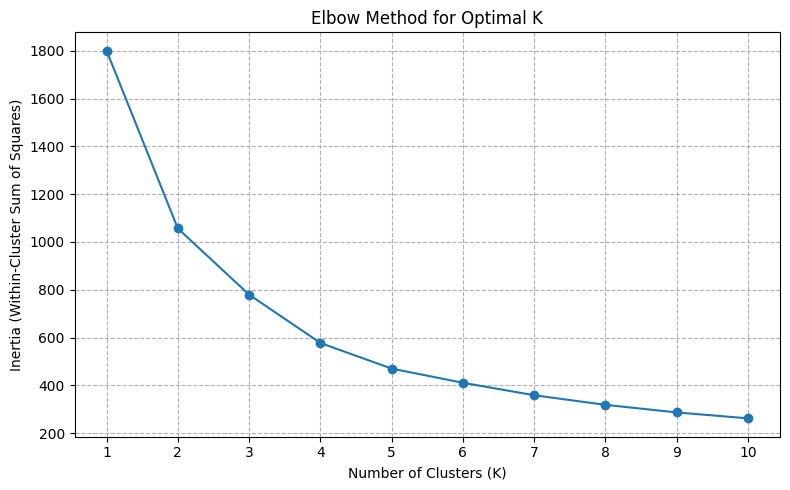

Selected K = 4 based on Elbow Method (or prior knowledge).
Assigned HCPs to 4 segments.

--- 4. Analyzing Segment Profiles ---

Segment Analysis (Average values per segment):
   segment  total_rx_post_launch  cg_rx_post_launch  cg_share_post_launch  \
0        0                 95.07              19.41                  0.21   
1        1                159.08              16.35                  0.10   
2        2                161.22              39.46                  0.25   
3        3                102.27               4.56                  0.05   

   unique_patients_post_launch  cg_patients_post_launch  days_to_first_cg_rx  \
0                        92.55                    19.24                91.37   
1                       152.10                    16.22               115.12   
2                       154.40                    39.12                72.85   
3                        99.43                     4.54               248.16   

   segment_size  
0            86  
1 

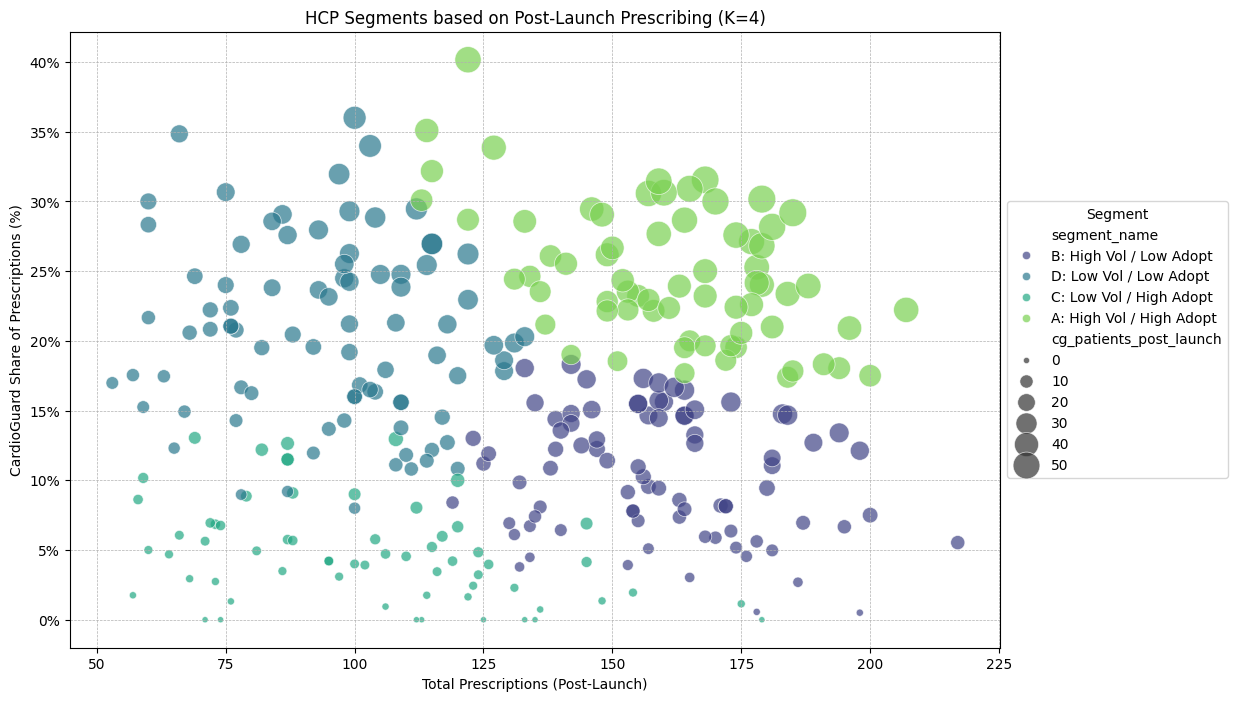


--- 6. Example Targeting Recommendations ---

Identified 83 HCPs in the 'B: High Vol / Low Adopt' segment (Potential for Growth).
Top 5 HCPs in this Segment (by Total Rx):
     hcp_id   specialty  total_rx_post_launch  cg_share_post_launch
142     642         PCP                   217              0.055300
171     671  Cardiology                   200              0.075000
24      524  Geriatrics                   198              0.005051
187     687  Geriatrics                   198              0.121212
285     785  Geriatrics                   195              0.066667

Identified 68 HCPs in the 'A: High Vol / High Adopt' segment (Maintain Relationship).

--- HCP Segmentation and Targeting Analysis Complete ---


In [ ]:
# Cell 5: HCP Segmentation and Targeting (run after preprocessing in Cell 3)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for directory creation and path joining

# Libraries needed for clustering
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    print("Scikit-learn libraries already available.")
except ImportError:
    print("Scikit-learn not found. Installing...")
    !pip install -q scikit-learn # -q for quieter installation
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    print("Scikit-learn installed and imported.")


# --- Check if df and hcps_df exist ---
if 'df' not in locals() or 'hcps_df' not in locals():
    print("Error: DataFrame 'df' or 'hcps_df' not found.")
    print("Please run the data generation (Cell 2) and preprocessing (Cell 3) cells first.")
    raise NameError("Required DataFrames not defined.")
else:
    print("DataFrames 'df' and 'hcps_df' found. Starting HCP Segmentation.")

# Ensure launch date is defined
CARDIOGUARD_LAUNCH_DATE = pd.to_datetime("2023-06-01")

# --- Create Figures Directory ---
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)
print(f"Ensured output directory '{figures_dir}' exists for saving plots.")


# --- 1. Calculate HCP-Level Metrics (Focus on Post-Launch Period) ---
print("\n--- 1. Calculating HCP-Level Metrics (Post-Launch) ---")
post_launch_df = df[df['prescription_date'] >= CARDIOGUARD_LAUNCH_DATE].copy()

if post_launch_df.empty:
     print("Warning: No prescriptions found after the CardioGuard launch date. Cannot perform HCP segmentation based on post-launch data.")
     # For this example, we'll stop if no post-launch data exists.
     raise ValueError("No post-launch data available for HCP segmentation.")
else:
    print(f"Analyzing {len(post_launch_df)} prescriptions from {post_launch_df['prescription_date'].min().strftime('%Y-%m-%d')} onwards.")
    hcp_metrics = post_launch_df.groupby('hcp_id').agg(
        total_rx_post_launch = pd.NamedAgg(column='prescription_id', aggfunc='count'),
        cg_rx_post_launch = pd.NamedAgg(column='is_cardioguard', aggfunc='sum'),
        unique_patients_post_launch = pd.NamedAgg(column='patient_id', aggfunc='nunique'),
        cg_patients_post_launch = pd.NamedAgg(column='patient_id', aggfunc=lambda x: post_launch_df.loc[x.index[post_launch_df.loc[x.index, 'is_cardioguard']], 'patient_id'].nunique()),
        first_cg_rx_date = pd.NamedAgg(column='prescription_date', aggfunc=lambda x: x[post_launch_df.loc[x.index, 'is_cardioguard']].min(skipna=True))
    ).reset_index()
    hcp_metrics = pd.merge(hcp_metrics, hcps_df[['hcp_id', 'specialty', 'zip_prefix']], on='hcp_id', how='left')

    # --- 2. Calculate Derived Metrics ---
    print("\n--- 2. Calculating Derived HCP Metrics ---")
    hcp_metrics['cg_share_post_launch'] = (hcp_metrics['cg_rx_post_launch'] / hcp_metrics['total_rx_post_launch']).fillna(0)
    hcp_metrics['days_to_first_cg_rx'] = (hcp_metrics['first_cg_rx_date'] - CARDIOGUARD_LAUNCH_DATE).dt.days
    max_days_observed = (post_launch_df['prescription_date'].max() - CARDIOGUARD_LAUNCH_DATE).days
    fill_value_for_nan_days = max_days_observed + 90
    hcp_metrics['days_to_first_cg_rx'] = hcp_metrics['days_to_first_cg_rx'].fillna(fill_value_for_nan_days)
    print("Derived metrics calculated (Share, Days to First Rx).")
    print("\nSample HCP Metrics:")
    print(hcp_metrics.head())

    # --- 3. HCP Segmentation using K-Means ---
    print("\n--- 3. Performing HCP Segmentation using K-Means ---")
    features_for_clustering = ['total_rx_post_launch', 'cg_rx_post_launch', 'cg_share_post_launch', 'unique_patients_post_launch', 'cg_patients_post_launch', 'days_to_first_cg_rx']
    hcp_cluster_data = hcp_metrics[features_for_clustering].copy()
    if hcp_cluster_data.isnull().sum().any():
        print("Warning: Missing values found before scaling. Filling with 0.")
        hcp_cluster_data = hcp_cluster_data.fillna(0)

    print("Scaling features...")
    scaler = StandardScaler()
    hcp_cluster_data_scaled = scaler.fit_transform(hcp_cluster_data)
    print("Features scaled.")

    print("Determining optimal K using Elbow Method...")
    inertia = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(hcp_cluster_data_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "05_hcp_segmentation_elbow.png") # Added number prefix
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()


    # --- Choose K and Run Final K-Means ---
    OPTIMAL_K = 4 # Adjust based on your elbow plot if needed
    print(f"Selected K = {OPTIMAL_K} based on Elbow Method (or prior knowledge).")
    kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
    hcp_metrics['segment'] = kmeans.fit_predict(hcp_cluster_data_scaled)
    print(f"Assigned HCPs to {OPTIMAL_K} segments.")

    # --- 4. Analyze and Profile Segments ---
    print("\n--- 4. Analyzing Segment Profiles ---")
    segment_analysis = hcp_metrics.groupby('segment')[features_for_clustering].mean()
    segment_analysis['segment_size'] = hcp_metrics['segment'].value_counts().sort_index()
    segment_analysis = segment_analysis.reset_index()
    print("\nSegment Analysis (Average values per segment):")
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(segment_analysis)
    pd.reset_option('display.float_format')

    # --- Interpret and Name Segments (Example) ---
    segment_names = {}
    segment_analysis_sorted = segment_analysis.sort_values('total_rx_post_launch', ascending=False)
    # Adjust naming based on your actual segment analysis table results
    try:
        segment_names[segment_analysis_sorted.iloc[0]['segment']] = "A: High Vol / High Adopt"
        segment_names[segment_analysis_sorted.iloc[1]['segment']] = "B: High Vol / Low Adopt" # Example, check your data
        segment_names[segment_analysis_sorted.iloc[2]['segment']] = "C: Low Vol / High Adopt" # Example
        segment_names[segment_analysis_sorted.iloc[3]['segment']] = "D: Low Vol / Low Adopt" # Example
    except IndexError:
        print("Warning: Could not assign names dynamically, check number of segments vs. naming logic.")
    # Assign default names if dynamic naming failed or K != 4
    for seg_id in range(OPTIMAL_K):
        if seg_id not in segment_names: segment_names[seg_id] = f"Segment {seg_id}"

    hcp_metrics['segment_name'] = hcp_metrics['segment'].map(segment_names)
    print("\nAssigned descriptive names to segments.")
    print(hcp_metrics[['hcp_id', 'specialty'] + features_for_clustering + ['segment_name']].head())

    # --- 5. Visualize Segments ---
    print("\n--- 5. Visualizing HCP Segments ---")
    plt.figure(figsize=(12, 8))
    scatter_plot = sns.scatterplot( # Assign plot to variable
        data=hcp_metrics, x='total_rx_post_launch', y='cg_share_post_launch',
        hue='segment_name', size='cg_patients_post_launch', sizes=(20, 400),
        palette='viridis', alpha=0.7
    )
    plt.title(f'HCP Segments based on Post-Launch Prescribing (K={OPTIMAL_K})')
    plt.xlabel('Total Prescriptions (Post-Launch)')
    plt.ylabel('CardioGuard Share of Prescriptions (%)')
    if hcp_metrics['total_rx_post_launch'].max() / hcp_metrics['total_rx_post_launch'].min() > 50:
       plt.xscale('log'); plt.xlabel('Total Prescriptions (Post-Launch) [Log Scale]')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    # Place legend outside plot using the plot object
    scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='Segment')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect instead if bbox_inches='tight' used below
    # --- SAVE FIGURE ---
    save_path = os.path.join(figures_dir, "06_hcp_segmentation_scatter.png") # Added number prefix
    try:
        # Use bbox_inches='tight' to try and capture the external legend
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved graph: {save_path}")
    except Exception as e:
        print(f"Error saving graph {save_path}: {e}")
    # --- END SAVE ---
    plt.show()


    # --- 6. Targeting Recommendations (Example) ---
    print("\n--- 6. Example Targeting Recommendations ---")
    # --- Define target segments based on your assigned names ---
    # Make sure these names EXACTLY match the keys in your segment_names dictionary after assignment
    high_potential_segment_name = "B: High Vol / Low Adopt" # Adjust name based on your results/naming
    loyalist_segment_name = "A: High Vol / High Adopt"      # Adjust name based on your results/naming

    target_hcps = hcp_metrics[hcp_metrics['segment_name'] == high_potential_segment_name]
    maintain_hcps = hcp_metrics[hcp_metrics['segment_name'] == loyalist_segment_name]

    if not target_hcps.empty:
        print(f"\nIdentified {len(target_hcps)} HCPs in the '{high_potential_segment_name}' segment (Potential for Growth).")
        print("Top 5 HCPs in this Segment (by Total Rx):")
        print(target_hcps.sort_values('total_rx_post_launch', ascending=False).head()[['hcp_id', 'specialty', 'total_rx_post_launch', 'cg_share_post_launch']])
    else:
        print(f"No HCPs found in the designated '{high_potential_segment_name}' segment.")

    if not maintain_hcps.empty:
        print(f"\nIdentified {len(maintain_hcps)} HCPs in the '{loyalist_segment_name}' segment (Maintain Relationship).")
    else:
        print(f"No HCPs found in the designated '{loyalist_segment_name}' segment.")


print("\n--- HCP Segmentation and Targeting Analysis Complete ---")